# Stochastic Policy Search Methods 

## Introduction
In Reinforcement Learning, agents try to derive optimal policies for maximising return by learning from their interaction with the environment.  

One way to achieve this is to use **value-based methods** where agents use their experience to gradually learn the value of particular actions in different states either by building a lookup table or performing function approximation using a deep neural network.  

Another approach is to use **policy-based methods**, where the intermediate step of estimating a value function is skipped. Instead, a neural network is sued which accepts the state as input and outputs a probability for performing each action available to the agent at each timestep. The policy is thus represented by the weights learnt by the neural network during the agent's interaction with the environment; its goal is to find the mathematical relationship between network weights *w* and the expected return *J* which maximises *J* in the environment. In other words, it is trying to maximise a function J by controlling the network's parameters w, of which J is a function.  

**Hill Climbing** is a simple optimization approach where the agent begins by initialising its policy network with random weights, then collects a single episode under its current policy (corresponding to those weights) and records the return. It then adds random noise to its current weights and collects another episode, this time using the policy corresponding to its noise-updated weights:

- If the return obtained with the new policy is greater than the previous policy's, it keeps the new weights;
- Otherwise, it reverts to the previous policy.

We will use the openAI gym environment *Cartpole*. Beyond the basic Hill-Climbing optimisation algorithm described above, we will explore 3 refinements:
- **Adaptive Noise Scaling**: the factor applied to scaling the noise added to weights during updating is scaled depending on whether we're improving upon the previous policy or not. If a weight update results in improved return, we will reduce the step size in our parameter exploration so as not to take a step so big it would overshoot a maximum and land us on the other side. Conversely, if a weight update results in worse return, we increase the step size (magnitude of noise added) in the hope of reaching a set of parameters that increases return.
- **Steepest Ascent Hill Climbing**: we choose a number of neighbouring policies at each iteration and pick the best-performing one amongst them.
- **Cross-Entropy**: we perform steepest ascent hill climbing but instead of picking just the policy with highest return, we select the top-k policies and take the average between them.

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import heapq
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box(4,)
action space: Discrete(2)


c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Defining a Policy Network
Cartpole is an environment with a continuous, 4-dimensional state space, and a discrete 2-dimensional action space. Our Policy Network will therefore have 4 inputs and 2 outputs. We will use Softmax as our activation function, since we wish the output to be the probability of performing each action, and the total probability should sum up to 1.
```Python
class PolicyNet():
    def __init__(self, pop_size, s_size=4, a_size=2, noise=1e-2, noise_min=1e-3, noise_max=2):```
We also define 3 noise parameters:
- noise: the scaling factor to apply to the random values we generate for weight updating;
- noise_min and noise_max: the upper and lower bounds for adaptive noise scaling.


In [3]:
class PolicyNet():
    def __init__(self, pop_size, s_size=4, a_size=2, noise=1e-2, noise_min=1e-3, noise_max=2):
        self.w = 1e-4*np.random.rand(s_size, a_size)
        self.noise = noise
        self.nmin = noise_min
        self.nmax = noise_max
        self.popsize = pop_size
        
    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x)/sum(np.exp(x))#softmax(x)
    
    def act(self, state, stochastic=False):
        probs = self.forward(state)
        if stochastic == False:
            action = np.argmax(probs)
        else:
            action = np.random.choice(2, p=probs)
        return action
    
    def populate(self):
        population = np.array([self.w + self.noise*np.random.rand(*self.w.shape) for _ in range(self.popsize)])
        return population

In [4]:
def hill_climbing(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = []
        state=env.reset()
        
        for t in range(max_t):
            action = policy.act(state)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
                
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        if R >= best_R:
            best_R = R
            best_w = policy.w
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w += policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
            
    return scores

Episode 100	Average Score: 115.76
Episode 200	Average Score: 191.62
Episode 300	Average Score: 193.25
Episode 400	Average Score: 192.73
Episode 500	Average Score: 188.14
Episode 600	Average Score: 191.92
Episode 700	Average Score: 181.88
Episode 800	Average Score: 186.54
Episode 900	Average Score: 185.79
Episode 1000	Average Score: 188.10


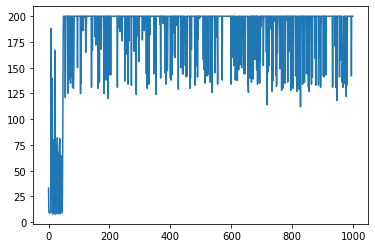

In [6]:
policy = PolicyNet(pop_size=1)
scores = hill_climbing(policy)
plt.plot(scores)

In [9]:
def steepest_hill_climbing(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = np.zeros((max_t, policy.popsize))
        policies = policy.populate()
        state_alpha = env.reset()
        
        for p in range(policy.popsize):
            policy.w = policies[p]
            state = state_alpha
            
            for t in range(max_t):
                action = policy.act(state)
                state, reward, done, _ = env.step(action)
                rewards[t,p] = reward
                if done:
                    break
        
        discounts = np.array([gamma**i for i in range(1000)])
        returns = np.sum(np.array([a*b for a,b in zip(rewards, discounts)]), axis = 0)
                
        best_p = np.argmax(returns)
        if returns[best_p] >= best_R:
            best_R = returns[best_p]
            best_w = policies[best_p]
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
                
        scores_deque.append(np.sum(rewards[:,best_p]))
        scores.append(np.sum(rewards[:,best_p]))
        
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
            
    return scores

In [10]:
policy = PolicyNet(pop_size=50)
scores_steepest = steepest_hill_climbing(policy)

Episode 100	Average Score: 111.57
Environment solved in 150 episodes!	Average Score: 196.42


array([[4.03391198, 4.28917409],
       [4.46150503, 5.51902406],
       [4.89189485, 5.86428271],
       [2.54878628, 4.14768754]])

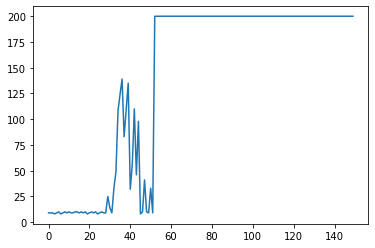

In [11]:
plt.plot(scores_steepest)
policy.w

In [ ]:
from IPython import display
torender_episodes = 3
torender_frames = 100

plt.figure(figsize=(9,9))

for i in range(0,torender_episodes):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(torender_frames):
        action = policy.act(state)
        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        plt.text(50,50,j)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        plt.text(50,50.'')
        if done:
            break 

env.close()

In [13]:
def steepest_hill_climbing_topk(policy, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100, topk=10):
    scores_deque = deque(maxlen=100)
    scores = []
    best_R = -np.Inf
    best_w = policy.w
    
    for i_episode in range(1, n_episodes+1):
        rewards = np.zeros((max_t, policy.popsize))
        policies = policy.populate()
        state_alpha = env.reset()
        
        for p in range(policy.popsize):
            policy.w = policies[p]
            state = state_alpha
            
            for t in range(max_t):
                action = policy.act(state)
                state, reward, done, _ = env.step(action)
                rewards[t,p] = reward
                if done:
                    break
        
        discounts = np.array([gamma**i for i in range(1000)])
        returns = np.sum(np.array([a*b for a,b in zip(rewards, discounts)]), axis = 0)
                
        best_p = np.argmax(returns)
        
        top_k = heapq.nlargest( topk , range(len(returns)), returns.__getitem__)
        
        if returns[best_p] >= best_R:
            best_R = returns[best_p]
            best_w = np.mean(policies[top_k],axis=0)
            policy.noise = max(policy.nmin, policy.noise/2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
        else:
            policy.noise = min(policy.nmax, policy.noise*2)
            policy.w = best_w + policy.noise * np.random.rand(*policy.w.shape)
                
        scores_deque.append(np.sum(rewards[:,best_p]))
        scores.append(np.sum(rewards[:,best_p]))
        
            
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            policy.w = best_w
            break
            
    return scores

In [14]:
policy = PolicyNet(pop_size=100)
scores_steepest = steepest_hill_climbing_topk(policy, topk=10)

c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 117.41
Environment solved in 157 episodes!	Average Score: 195.95


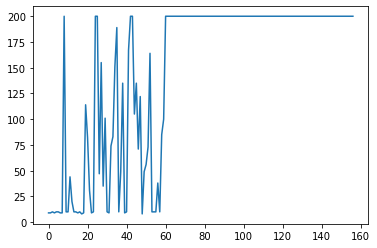

In [15]:
plt.plot(scores_steepest)

In [ ]:
scores_stochastic = []
scores_steepest = []
scores_evo = []

for i in range(5000):
    policy_stochastic = PolicyNet(pop_size=1)
    scores_stochastic.append(hill_climbing(policy_stochastic));
    
    policy_steepest = PolicyNet(pop_size=50)
    scores_steepest.append(steepest_hill_climbing(policy_steepest));
    
    policy_steepest_evo = PolicyNet(pop_size=50)
    scores_evo.append(steepest_hill_climbing_topk(policy_steepest_evo,topk=10));

Environment solved in 95 episodes!	Average Score: 195.03


c:\users\andre\desktop\udacity drl\gym\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 162.41
Environment solved in 123 episodes!	Average Score: 196.20
Episode 100	Average Score: 134.53
Environment solved in 160 episodes!	Average Score: 195.84
Episode 100	Average Score: 166.53
Environment solved in 119 episodes!	Average Score: 195.63
Episode 100	Average Score: 171.91
Episode 200	Average Score: 192.76
Environment solved in 253 episodes!	Average Score: 195.07
Episode 100	Average Score: 166.47
Environment solved in 116 episodes!	Average Score: 195.48
Episode 100	Average Score: 189.49
Environment solved in 105 episodes!	Average Score: 196.51
Episode 100	Average Score: 146.64
Environment solved in 132 episodes!	Average Score: 195.88
Episode 100	Average Score: 157.28
Environment solved in 130 episodes!	Average Score: 195.81
Episode 100	Average Score: 126.53
Environment solved in 144 episodes!	Average Score: 195.61
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 164.17
Environment solved in 123 episodes!	Average Scor

Episode 100	Average Score: 77.17
Environment solved in 168 episodes!	Average Score: 196.68
Episode 100	Average Score: 137.39
Environment solved in 133 episodes!	Average Score: 195.11
Episode 100	Average Score: 125.20
Episode 200	Average Score: 163.41
Environment solved in 281 episodes!	Average Score: 195.38
Episode 100	Average Score: 135.63
Environment solved in 140 episodes!	Average Score: 195.01
Episode 100	Average Score: 152.50
Environment solved in 134 episodes!	Average Score: 195.47
Episode 100	Average Score: 150.66
Environment solved in 134 episodes!	Average Score: 196.44
Episode 100	Average Score: 130.48
Environment solved in 147 episodes!	Average Score: 196.17
Episode 100	Average Score: 169.10
Environment solved in 120 episodes!	Average Score: 196.49
Episode 100	Average Score: 148.27
Environment solved in 129 episodes!	Average Score: 195.41
Episode 100	Average Score: 126.46
Environment solved in 153 episodes!	Average Score: 195.84
Episode 100	Average Score: 148.46
Episode 200	A

Episode 100	Average Score: 124.35
Episode 200	Average Score: 148.34
Episode 300	Average Score: 105.64
Episode 400	Average Score: 131.53
Episode 500	Average Score: 162.22
Episode 600	Average Score: 160.87
Episode 700	Average Score: 170.14
Episode 800	Average Score: 184.33
Episode 900	Average Score: 183.01
Episode 1000	Average Score: 185.85
Episode 100	Average Score: 154.75
Environment solved in 122 episodes!	Average Score: 195.51
Episode 100	Average Score: 100.70
Environment solved in 165 episodes!	Average Score: 195.43
Episode 100	Average Score: 186.24
Environment solved in 106 episodes!	Average Score: 196.78
Episode 100	Average Score: 134.05
Episode 200	Average Score: 161.38
Episode 300	Average Score: 171.37
Episode 400	Average Score: 157.02
Episode 500	Average Score: 165.73
Episode 600	Average Score: 154.83
Episode 700	Average Score: 144.22
Episode 800	Average Score: 163.97
Episode 900	Average Score: 155.19
Episode 1000	Average Score: 162.77
Environment solved in 2 episodes!	Average 

Environment solved in 170 episodes!	Average Score: 195.97
Episode 100	Average Score: 174.57
Environment solved in 117 episodes!	Average Score: 195.34
Episode 100	Average Score: 137.92
Environment solved in 143 episodes!	Average Score: 196.39
Episode 100	Average Score: 188.34
Environment solved in 104 episodes!	Average Score: 195.23
Episode 100	Average Score: 166.74
Environment solved in 121 episodes!	Average Score: 196.59
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 147.32
Episode 200	Average Score: 170.46
Episode 300	Average Score: 176.22
Episode 400	Average Score: 175.06
Episode 500	Average Score: 169.82
Episode 600	Average Score: 162.61
Episode 700	Average Score: 159.87
Episode 800	Average Score: 157.30
Episode 900	Average Score: 159.94
Episode 1000	Average Score: 167.64
Episode 100	Average Score: 136.44
Environment solved in 145 episodes!	Average Score: 196.66
Episode 100	Average Score: 155.25
Environment solved in 127 episodes!	Average Score: 

C:\Users\Andre\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Andre\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Episode 500	Average Score: 163.71
Episode 600	Average Score: 165.26
Episode 700	Average Score: 156.02
Episode 800	Average Score: 160.51
Episode 900	Average Score: 155.12


C:\Users\Andre\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Episode 1000	Average Score: 170.23
Episode 100	Average Score: 179.18
Episode 200	Average Score: 189.93
Environment solved in 227 episodes!	Average Score: 195.67
Episode 100	Average Score: 176.39
Environment solved in 110 episodes!	Average Score: 195.47
Episode 100	Average Score: 106.32
Environment solved in 163 episodes!	Average Score: 196.20
Episode 100	Average Score: 160.70
Environment solved in 153 episodes!	Average Score: 195.68
Episode 100	Average Score: 145.51
Environment solved in 139 episodes!	Average Score: 195.28
Episode 100	Average Score: 66.56
Episode 200	Average Score: 187.93
Environment solved in 207 episodes!	Average Score: 195.53
Episode 100	Average Score: 73.76
Episode 200	Average Score: 173.02
Episode 300	Average Score: 167.45
Episode 400	Average Score: 168.63
Episode 500	Average Score: 164.74
Episode 600	Average Score: 160.40
Episode 700	Average Score: 165.94
Episode 800	Average Score: 163.66
Episode 900	Average Score: 169.59
Episode 1000	Average Score: 165.50
Episod

Episode 100	Average Score: 140.00
Environment solved in 139 episodes!	Average Score: 196.06
Episode 100	Average Score: 152.47
Environment solved in 124 episodes!	Average Score: 195.76
Episode 100	Average Score: 168.99
Environment solved in 127 episodes!	Average Score: 196.79
Episode 100	Average Score: 136.86
Episode 200	Average Score: 180.34
Episode 300	Average Score: 185.05
Episode 400	Average Score: 185.96
Episode 500	Average Score: 183.13
Episode 600	Average Score: 185.82
Episode 700	Average Score: 180.61
Episode 800	Average Score: 175.40
Episode 900	Average Score: 181.20
Episode 1000	Average Score: 177.43
Environment solved in 1 episodes!	Average Score: 195.00
Episode 100	Average Score: 176.07
Environment solved in 132 episodes!	Average Score: 195.01
Episode 100	Average Score: 126.30
Episode 200	Average Score: 155.57
Episode 300	Average Score: 155.02
Episode 400	Average Score: 155.95
Environment solved in 481 episodes!	Average Score: 195.89
Episode 100	Average Score: 181.17
Environ

Episode 100	Average Score: 134.39
Episode 200	Average Score: 190.81
Episode 300	Average Score: 187.27
Episode 400	Average Score: 186.61
Episode 500	Average Score: 193.61
Episode 600	Average Score: 193.90
Environment solved in 679 episodes!	Average Score: 195.13
Episode 100	Average Score: 162.18
Environment solved in 126 episodes!	Average Score: 195.16
Episode 100	Average Score: 133.95
Environment solved in 144 episodes!	Average Score: 195.11
Episode 100	Average Score: 133.29
Episode 200	Average Score: 188.39
Episode 300	Average Score: 194.26
Environment solved in 315 episodes!	Average Score: 195.12
Episode 100	Average Score: 185.99
Environment solved in 109 episodes!	Average Score: 196.32
Episode 100	Average Score: 149.11
Environment solved in 147 episodes!	Average Score: 195.18
Episode 100	Average Score: 162.83
Environment solved in 126 episodes!	Average Score: 195.39
Episode 100	Average Score: 192.50
Environment solved in 102 episodes!	Average Score: 195.22
Episode 100	Average Score:

Episode 100	Average Score: 86.36
Environment solved in 193 episodes!	Average Score: 195.00
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 152.30
Environment solved in 124 episodes!	Average Score: 195.34
Episode 100	Average Score: 164.50
Environment solved in 124 episodes!	Average Score: 195.23
Episode 100	Average Score: 159.60
Environment solved in 122 episodes!	Average Score: 195.27
Episode 100	Average Score: 138.83
Episode 200	Average Score: 141.12
Environment solved in 284 episodes!	Average Score: 195.19
Episode 100	Average Score: 178.06
Environment solved in 121 episodes!	Average Score: 195.57
Episode 100	Average Score: 154.58
Environment solved in 135 episodes!	Average Score: 196.36
Episode 100	Average Score: 177.62
Environment solved in 111 episodes!	Average Score: 195.14
Episode 100	Average Score: 171.94
Environment solved in 125 episodes!	Average Score: 196.20
Episode 100	Average Score: 161.15
Environment solved in 126 episodes!	Average Score

Episode 100	Average Score: 143.13
Environment solved in 133 episodes!	Average Score: 195.97
Episode 100	Average Score: 179.04
Environment solved in 111 episodes!	Average Score: 196.58
Episode 100	Average Score: 192.60
Environment solved in 102 episodes!	Average Score: 195.08
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 180.20
Environment solved in 110 episodes!	Average Score: 195.86
Episode 100	Average Score: 167.25
Environment solved in 123 episodes!	Average Score: 195.10
Episode 100	Average Score: 183.52
Environment solved in 107 episodes!	Average Score: 195.89
Episode 100	Average Score: 145.20
Environment solved in 133 episodes!	Average Score: 196.38
Episode 100	Average Score: 172.88
Environment solved in 131 episodes!	Average Score: 196.27
Episode 100	Average Score: 154.90
Environment solved in 125 episodes!	Average Score: 196.65
Episode 100	Average Score: 116.90
Environment solved in 156 episodes!	Average Score: 196.59
Episode 100	Average Scor

Episode 100	Average Score: 171.69
Environment solved in 169 episodes!	Average Score: 195.71
Episode 100	Average Score: 73.94
Environment solved in 180 episodes!	Average Score: 195.28
Episode 100	Average Score: 144.63
Environment solved in 130 episodes!	Average Score: 196.29
Episode 100	Average Score: 154.61
Episode 200	Average Score: 163.17
Episode 300	Average Score: 168.70
Episode 400	Average Score: 170.72
Episode 500	Average Score: 165.57
Episode 600	Average Score: 156.34
Episode 700	Average Score: 152.03
Environment solved in 742 episodes!	Average Score: 195.16
Episode 100	Average Score: 123.94
Episode 200	Average Score: 149.21
Episode 300	Average Score: 186.64
Environment solved in 309 episodes!	Average Score: 196.03
Episode 100	Average Score: 167.06
Environment solved in 122 episodes!	Average Score: 195.01
Episode 100	Average Score: 166.96
Environment solved in 121 episodes!	Average Score: 195.72
Episode 100	Average Score: 133.61
Episode 200	Average Score: 153.56
Episode 300	Avera

Episode 100	Average Score: 179.27
Environment solved in 110 episodes!	Average Score: 195.68
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 144.23
Environment solved in 137 episodes!	Average Score: 196.18
Episode 100	Average Score: 102.58
Environment solved in 174 episodes!	Average Score: 196.19
Episode 100	Average Score: 176.31
Environment solved in 112 episodes!	Average Score: 195.21
Episode 100	Average Score: 91.32
Episode 200	Average Score: 192.65
Episode 300	Average Score: 192.04
Episode 400	Average Score: 191.51
Episode 500	Average Score: 188.38
Episode 600	Average Score: 191.11
Episode 700	Average Score: 187.96
Episode 800	Average Score: 189.54
Episode 900	Average Score: 191.67
Environment solved in 995 episodes!	Average Score: 195.38
Episode 100	Average Score: 98.68
Environment solved in 162 episodes!	Average Score: 195.74
Environment solved in 1 episodes!	Average Score: 197.00
Episode 100	Average Score: 176.45
Environment solved in 110 episod

Episode 100	Average Score: 176.74
Environment solved in 113 episodes!	Average Score: 195.62
Episode 100	Average Score: 131.92
Episode 200	Average Score: 175.44
Episode 300	Average Score: 174.57
Episode 400	Average Score: 178.44
Episode 500	Average Score: 172.96
Episode 600	Average Score: 173.32
Episode 700	Average Score: 170.72
Episode 800	Average Score: 173.20
Episode 900	Average Score: 175.19
Episode 1000	Average Score: 173.35
Episode 100	Average Score: 133.22
Environment solved in 140 episodes!	Average Score: 195.99
Episode 100	Average Score: 145.46
Environment solved in 155 episodes!	Average Score: 196.19
Episode 100	Average Score: 183.53
Environment solved in 108 episodes!	Average Score: 195.77
Episode 100	Average Score: 65.67
Environment solved in 177 episodes!	Average Score: 195.06
Episode 100	Average Score: 160.96
Episode 200	Average Score: 157.06
Environment solved in 241 episodes!	Average Score: 195.91
Episode 100	Average Score: 171.81
Environment solved in 125 episodes!	Aver

Episode 300	Average Score: 172.05
Episode 400	Average Score: 162.28
Episode 500	Average Score: 161.40
Episode 600	Average Score: 155.59
Episode 700	Average Score: 155.16
Environment solved in 792 episodes!	Average Score: 195.03
Episode 100	Average Score: 145.38
Environment solved in 134 episodes!	Average Score: 195.07
Episode 100	Average Score: 173.50
Environment solved in 127 episodes!	Average Score: 195.24
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 168.80
Environment solved in 118 episodes!	Average Score: 196.41
Episode 100	Average Score: 124.89
Episode 200	Average Score: 175.99
Episode 300	Average Score: 175.93
Episode 400	Average Score: 176.61
Environment solved in 467 episodes!	Average Score: 195.28
Episode 100	Average Score: 115.38
Environment solved in 182 episodes!	Average Score: 195.57
Episode 100	Average Score: 136.44
Environment solved in 142 episodes!	Average Score: 195.53
Episode 100	Average Score: 180.89
Environment solved in 109 ep

Environment solved in 144 episodes!	Average Score: 196.67
Episode 100	Average Score: 112.90
Episode 200	Average Score: 146.41
Episode 300	Average Score: 142.83
Episode 400	Average Score: 166.16
Episode 500	Average Score: 168.16
Episode 600	Average Score: 173.48
Episode 700	Average Score: 170.58
Episode 800	Average Score: 156.17
Episode 900	Average Score: 174.90
Episode 1000	Average Score: 170.23
Episode 100	Average Score: 130.71
Environment solved in 155 episodes!	Average Score: 195.90
Episode 100	Average Score: 102.63
Environment solved in 174 episodes!	Average Score: 195.22
Episode 100	Average Score: 184.78
Environment solved in 108 episodes!	Average Score: 196.44
Episode 100	Average Score: 161.34
Environment solved in 133 episodes!	Average Score: 196.32
Episode 100	Average Score: 159.07
Environment solved in 125 episodes!	Average Score: 195.07
Episode 100	Average Score: 150.33
Environment solved in 137 episodes!	Average Score: 195.11
Episode 100	Average Score: 167.87
Environment sol

Episode 100	Average Score: 94.86
Episode 200	Average Score: 178.09
Episode 300	Average Score: 181.00
Episode 400	Average Score: 177.99
Episode 500	Average Score: 180.36
Episode 600	Average Score: 177.54
Episode 700	Average Score: 170.60
Episode 800	Average Score: 178.06
Episode 900	Average Score: 172.43
Episode 1000	Average Score: 181.04
Episode 100	Average Score: 32.99
Episode 200	Average Score: 168.30
Environment solved in 221 episodes!	Average Score: 195.14
Episode 100	Average Score: 141.69
Episode 200	Average Score: 172.64
Episode 300	Average Score: 168.19
Episode 400	Average Score: 168.76
Episode 500	Average Score: 170.41
Episode 600	Average Score: 163.98
Episode 700	Average Score: 169.55
Episode 800	Average Score: 168.75
Episode 900	Average Score: 168.51
Episode 1000	Average Score: 165.38
Episode 100	Average Score: 167.86
Environment solved in 137 episodes!	Average Score: 195.16
Episode 100	Average Score: 137.48
Environment solved in 138 episodes!	Average Score: 196.03
Episode 10

Episode 100	Average Score: 186.26
Environment solved in 106 episodes!	Average Score: 196.17
Episode 100	Average Score: 96.97
Environment solved in 159 episodes!	Average Score: 196.17
Episode 100	Average Score: 179.01
Environment solved in 110 episodes!	Average Score: 196.20
Episode 100	Average Score: 178.73
Environment solved in 117 episodes!	Average Score: 196.20
Episode 100	Average Score: 121.60
Episode 200	Average Score: 158.41
Environment solved in 238 episodes!	Average Score: 195.40
Episode 100	Average Score: 144.27
Episode 200	Average Score: 168.83
Episode 300	Average Score: 168.46
Episode 400	Average Score: 171.45
Episode 500	Average Score: 167.30
Episode 600	Average Score: 165.68
Episode 700	Average Score: 167.85
Episode 800	Average Score: 169.94
Episode 900	Average Score: 172.95
Episode 1000	Average Score: 170.47
Episode 100	Average Score: 175.97
Environment solved in 135 episodes!	Average Score: 195.00
Episode 100	Average Score: 168.18
Environment solved in 121 episodes!	Aver

Episode 100	Average Score: 124.98
Episode 200	Average Score: 194.26
Environment solved in 233 episodes!	Average Score: 195.32
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 107.73
Episode 200	Average Score: 192.34
Episode 300	Average Score: 191.71
Episode 400	Average Score: 193.30
Episode 500	Average Score: 190.21
Episode 600	Average Score: 192.04
Episode 700	Average Score: 192.61
Episode 800	Average Score: 194.72
Environment solved in 867 episodes!	Average Score: 195.15
Episode 100	Average Score: 190.27
Environment solved in 104 episodes!	Average Score: 195.41
Episode 100	Average Score: 179.31
Environment solved in 109 episodes!	Average Score: 195.99
Episode 100	Average Score: 159.07
Environment solved in 126 episodes!	Average Score: 195.73
Episode 100	Average Score: 167.46
Environment solved in 118 episodes!	Average Score: 196.59
Episode 100	Average Score: 143.98
Environment solved in 140 episodes!	Average Score: 195.29
Episode 100	Average Score: 1

Episode 1000	Average Score: 154.56
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 167.13
Environment solved in 137 episodes!	Average Score: 195.01
Episode 100	Average Score: 56.74
Episode 200	Average Score: 187.66
Environment solved in 206 episodes!	Average Score: 195.17
Episode 100	Average Score: 150.31
Environment solved in 129 episodes!	Average Score: 196.43
Episode 100	Average Score: 182.40
Environment solved in 127 episodes!	Average Score: 195.48
Episode 100	Average Score: 144.10
Environment solved in 134 episodes!	Average Score: 195.69
Episode 100	Average Score: 138.22
Environment solved in 138 episodes!	Average Score: 196.37
Episode 100	Average Score: 161.15
Environment solved in 129 episodes!	Average Score: 196.82
Episode 100	Average Score: 172.89
Episode 200	Average Score: 184.16
Environment solved in 256 episodes!	Average Score: 195.77
Episode 100	Average Score: 191.67
Environment solved in 102 episodes!	Average Score: 195.32
Episode 100	Av

Episode 800	Average Score: 176.16
Episode 900	Average Score: 177.19
Episode 1000	Average Score: 194.46
Episode 100	Average Score: 163.23
Environment solved in 134 episodes!	Average Score: 195.07
Episode 100	Average Score: 163.49
Environment solved in 122 episodes!	Average Score: 195.40
Episode 100	Average Score: 162.91
Episode 200	Average Score: 192.74
Episode 300	Average Score: 194.52
Environment solved in 313 episodes!	Average Score: 195.16
Episode 100	Average Score: 153.59
Episode 200	Average Score: 193.85
Episode 300	Average Score: 192.86
Environment solved in 370 episodes!	Average Score: 195.01
Episode 100	Average Score: 173.55
Environment solved in 125 episodes!	Average Score: 196.05
Episode 100	Average Score: 123.92
Environment solved in 142 episodes!	Average Score: 195.95
Episode 100	Average Score: 101.28
Episode 200	Average Score: 140.71
Episode 300	Average Score: 154.20
Episode 400	Average Score: 153.10
Episode 500	Average Score: 142.66
Episode 600	Average Score: 151.68
Episo

Episode 100	Average Score: 149.57
Environment solved in 126 episodes!	Average Score: 195.67
Episode 100	Average Score: 143.71
Environment solved in 154 episodes!	Average Score: 195.55
Episode 100	Average Score: 173.11
Environment solved in 114 episodes!	Average Score: 196.54
Episode 100	Average Score: 150.58
Environment solved in 127 episodes!	Average Score: 195.27
Episode 100	Average Score: 116.04
Environment solved in 156 episodes!	Average Score: 195.30
Episode 100	Average Score: 166.41
Environment solved in 122 episodes!	Average Score: 195.98
Episode 100	Average Score: 122.32
Environment solved in 148 episodes!	Average Score: 195.83
Episode 100	Average Score: 171.60
Environment solved in 125 episodes!	Average Score: 196.58
Episode 100	Average Score: 126.55
Episode 200	Average Score: 156.47
Episode 300	Average Score: 163.59
Episode 400	Average Score: 159.14
Episode 500	Average Score: 156.08
Episode 600	Average Score: 158.55
Episode 700	Average Score: 161.65
Episode 800	Average Score:

Episode 100	Average Score: 162.36
Environment solved in 124 episodes!	Average Score: 195.42
Episode 100	Average Score: 138.50
Environment solved in 136 episodes!	Average Score: 196.19
Episode 100	Average Score: 139.45
Environment solved in 143 episodes!	Average Score: 195.40
Episode 100	Average Score: 154.43
Environment solved in 133 episodes!	Average Score: 195.79
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 158.90
Episode 200	Average Score: 171.73
Environment solved in 272 episodes!	Average Score: 195.13
Episode 100	Average Score: 174.33
Environment solved in 119 episodes!	Average Score: 195.81
Episode 100	Average Score: 125.74
Episode 200	Average Score: 170.80
Episode 300	Average Score: 163.65
Episode 400	Average Score: 169.29
Episode 500	Average Score: 162.34
Episode 600	Average Score: 168.30
Episode 700	Average Score: 159.16
Episode 800	Average Score: 167.67
Episode 900	Average Score: 158.40
Episode 1000	Average Score: 168.69
Episode 100	Avera

Episode 100	Average Score: 158.97
Environment solved in 127 episodes!	Average Score: 195.04
Episode 100	Average Score: 180.74
Environment solved in 124 episodes!	Average Score: 196.16
Episode 100	Average Score: 133.54
Environment solved in 139 episodes!	Average Score: 196.30
Episode 100	Average Score: 186.39
Environment solved in 108 episodes!	Average Score: 196.24
Episode 100	Average Score: 170.64
Environment solved in 119 episodes!	Average Score: 195.84
Episode 100	Average Score: 143.04
Environment solved in 131 episodes!	Average Score: 196.80
Episode 100	Average Score: 151.81
Environment solved in 128 episodes!	Average Score: 196.09
Episode 100	Average Score: 165.73
Environment solved in 116 episodes!	Average Score: 195.06
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 148.48
Environment solved in 139 episodes!	Average Score: 195.97
Episode 100	Average Score: 64.96
Episode 200	Average Score: 189.63
Environment solved in 218 episodes!	Average Score

Environment solved in 160 episodes!	Average Score: 196.17
Episode 100	Average Score: 151.75
Episode 200	Average Score: 192.27
Episode 300	Average Score: 188.83
Episode 400	Average Score: 188.78
Episode 500	Average Score: 190.77
Episode 600	Average Score: 190.01
Episode 700	Average Score: 187.05
Episode 800	Average Score: 188.31
Episode 900	Average Score: 184.78
Episode 1000	Average Score: 185.30
Episode 100	Average Score: 157.42
Environment solved in 124 episodes!	Average Score: 196.11
Episode 100	Average Score: 101.82
Environment solved in 158 episodes!	Average Score: 196.60
Episode 100	Average Score: 180.59
Environment solved in 112 episodes!	Average Score: 196.69
Episode 100	Average Score: 149.78
Episode 200	Average Score: 182.70
Episode 300	Average Score: 180.65
Episode 400	Average Score: 179.40
Episode 500	Average Score: 180.37
Episode 600	Average Score: 181.04
Episode 700	Average Score: 188.89
Episode 800	Average Score: 192.88
Episode 900	Average Score: 189.19
Episode 1000	Averag

Episode 100	Average Score: 182.17
Environment solved in 159 episodes!	Average Score: 196.31
Episode 100	Average Score: 107.99
Episode 200	Average Score: 107.57
Episode 300	Average Score: 170.74
Environment solved in 334 episodes!	Average Score: 195.70
Episode 100	Average Score: 187.73
Environment solved in 105 episodes!	Average Score: 195.40
Episode 100	Average Score: 119.36
Environment solved in 161 episodes!	Average Score: 195.00
Episode 100	Average Score: 174.27
Environment solved in 118 episodes!	Average Score: 195.42
Episode 100	Average Score: 171.37
Episode 200	Average Score: 185.02
Episode 300	Average Score: 186.33
Episode 400	Average Score: 185.31
Episode 500	Average Score: 184.11
Episode 600	Average Score: 188.09
Episode 700	Average Score: 181.90
Episode 800	Average Score: 178.83
Episode 900	Average Score: 177.81
Episode 1000	Average Score: 176.37
Episode 100	Average Score: 90.59
Environment solved in 158 episodes!	Average Score: 195.58
Episode 100	Average Score: 112.95
Enviro

Episode 100	Average Score: 160.54
Environment solved in 129 episodes!	Average Score: 195.22
Episode 100	Average Score: 163.69
Environment solved in 121 episodes!	Average Score: 196.54
Episode 100	Average Score: 157.41
Environment solved in 136 episodes!	Average Score: 195.60
Episode 100	Average Score: 67.18
Episode 200	Average Score: 192.83
Environment solved in 299 episodes!	Average Score: 195.19
Episode 100	Average Score: 182.06
Environment solved in 110 episodes!	Average Score: 195.27
Episode 100	Average Score: 183.30
Environment solved in 108 episodes!	Average Score: 196.12
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 104.26
Environment solved in 173 episodes!	Average Score: 196.80
Episode 100	Average Score: 154.99
Environment solved in 130 episodes!	Average Score: 196.19
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 168.64
Environment solved in 120 episodes!	Average Score: 195.94
Episode 100	Average Score: 

Episode 100	Average Score: 136.81
Environment solved in 142 episodes!	Average Score: 196.56
Episode 100	Average Score: 147.56
Environment solved in 139 episodes!	Average Score: 196.07
Episode 100	Average Score: 146.50
Environment solved in 149 episodes!	Average Score: 195.04
Episode 100	Average Score: 40.24
Environment solved in 199 episodes!	Average Score: 196.91
Episode 100	Average Score: 177.80
Environment solved in 110 episodes!	Average Score: 195.11
Episode 100	Average Score: 101.72
Environment solved in 164 episodes!	Average Score: 195.18
Episode 100	Average Score: 143.72
Episode 200	Average Score: 166.30
Episode 300	Average Score: 171.04
Episode 400	Average Score: 169.26
Episode 500	Average Score: 170.95
Episode 600	Average Score: 167.13
Episode 700	Average Score: 172.55
Episode 800	Average Score: 165.29
Episode 900	Average Score: 175.59
Episode 1000	Average Score: 169.93
Episode 100	Average Score: 160.19
Environment solved in 137 episodes!	Average Score: 195.26
Episode 100	Aver

Episode 1000	Average Score: 166.53
Episode 100	Average Score: 85.53
Episode 200	Average Score: 162.42
Episode 300	Average Score: 174.51
Episode 400	Average Score: 168.14
Episode 500	Average Score: 159.59
Episode 600	Average Score: 171.36
Episode 700	Average Score: 171.29
Episode 800	Average Score: 173.05
Episode 900	Average Score: 167.22
Episode 1000	Average Score: 166.17
Episode 100	Average Score: 178.54
Environment solved in 116 episodes!	Average Score: 195.48
Episode 100	Average Score: 167.85
Environment solved in 170 episodes!	Average Score: 196.89
Episode 100	Average Score: 124.10
Episode 200	Average Score: 191.41
Episode 300	Average Score: 187.27
Environment solved in 355 episodes!	Average Score: 195.15
Episode 100	Average Score: 172.02
Environment solved in 119 episodes!	Average Score: 196.30
Episode 100	Average Score: 152.86
Environment solved in 131 episodes!	Average Score: 195.44
Episode 100	Average Score: 92.30
Environment solved in 163 episodes!	Average Score: 195.04
Episod

Episode 100	Average Score: 118.34
Environment solved in 161 episodes!	Average Score: 195.98
Episode 100	Average Score: 165.24
Environment solved in 147 episodes!	Average Score: 196.75
Episode 100	Average Score: 83.17
Episode 200	Average Score: 183.11
Environment solved in 215 episodes!	Average Score: 196.26
Episode 100	Average Score: 131.99
Environment solved in 142 episodes!	Average Score: 195.11
Episode 100	Average Score: 174.53
Environment solved in 113 episodes!	Average Score: 196.06
Episode 100	Average Score: 113.68
Environment solved in 156 episodes!	Average Score: 196.27
Episode 100	Average Score: 158.87
Environment solved in 125 episodes!	Average Score: 195.18
Episode 100	Average Score: 149.68
Environment solved in 138 episodes!	Average Score: 195.13
Episode 100	Average Score: 185.59
Environment solved in 105 episodes!	Average Score: 195.15
Episode 100	Average Score: 117.63
Episode 200	Average Score: 160.93
Episode 300	Average Score: 167.73
Episode 400	Average Score: 169.32
Epi

Episode 900	Average Score: 176.87
Episode 1000	Average Score: 165.36
Episode 100	Average Score: 138.50
Environment solved in 159 episodes!	Average Score: 196.50
Episode 100	Average Score: 190.13
Environment solved in 112 episodes!	Average Score: 195.85
Episode 100	Average Score: 137.00
Episode 200	Average Score: 184.41
Episode 300	Average Score: 184.77
Episode 400	Average Score: 190.22
Episode 500	Average Score: 186.77
Episode 600	Average Score: 182.62
Episode 700	Average Score: 132.50
Episode 800	Average Score: 146.47
Episode 900	Average Score: 145.46
Episode 1000	Average Score: 156.90
Episode 100	Average Score: 158.12
Environment solved in 129 episodes!	Average Score: 196.88
Episode 100	Average Score: 183.08
Environment solved in 108 episodes!	Average Score: 195.64
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 77.88
Episode 200	Average Score: 172.80
Environment solved in 228 episodes!	Average Score: 195.29
Environment solved in 1 episodes!	Average

Episode 100	Average Score: 99.87
Episode 200	Average Score: 125.52
Episode 300	Average Score: 151.33
Episode 400	Average Score: 150.13
Episode 500	Average Score: 161.35
Episode 600	Average Score: 157.09
Episode 700	Average Score: 153.46
Episode 800	Average Score: 151.72
Episode 900	Average Score: 162.86
Episode 1000	Average Score: 155.43
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 134.49
Environment solved in 132 episodes!	Average Score: 195.40
Episode 100	Average Score: 65.91
Episode 200	Average Score: 149.21
Environment solved in 228 episodes!	Average Score: 196.41
Episode 100	Average Score: 136.97
Environment solved in 150 episodes!	Average Score: 195.11
Episode 100	Average Score: 158.35
Environment solved in 121 episodes!	Average Score: 195.20
Episode 100	Average Score: 175.56
Environment solved in 115 episodes!	Average Score: 196.48
Episode 100	Average Score: 166.67
Environment solved in 128 episodes!	Average Score: 195.06
Episode 100	Average

Episode 100	Average Score: 119.22
Environment solved in 146 episodes!	Average Score: 196.20
Episode 100	Average Score: 87.74
Environment solved in 175 episodes!	Average Score: 195.04
Episode 100	Average Score: 180.99
Environment solved in 111 episodes!	Average Score: 196.17
Episode 100	Average Score: 181.56
Environment solved in 193 episodes!	Average Score: 195.57
Episode 100	Average Score: 82.36
Environment solved in 172 episodes!	Average Score: 196.26
Episode 100	Average Score: 130.98
Environment solved in 148 episodes!	Average Score: 195.24
Episode 100	Average Score: 193.57
Environment solved in 102 episodes!	Average Score: 196.02
Episode 100	Average Score: 131.91
Environment solved in 145 episodes!	Average Score: 196.40
Episode 100	Average Score: 187.61
Environment solved in 106 episodes!	Average Score: 195.51
Episode 100	Average Score: 173.18
Environment solved in 119 episodes!	Average Score: 195.62
Episode 100	Average Score: 178.23
Environment solved in 111 episodes!	Average Scor

Episode 500	Average Score: 190.52
Environment solved in 583 episodes!	Average Score: 195.24
Episode 100	Average Score: 148.16
Environment solved in 133 episodes!	Average Score: 196.89
Episode 100	Average Score: 127.05
Episode 200	Average Score: 191.26
Episode 300	Average Score: 194.11
Episode 400	Average Score: 191.88
Episode 500	Average Score: 192.91
Episode 600	Average Score: 192.55
Episode 700	Average Score: 194.24
Episode 800	Average Score: 193.97
Environment solved in 810 episodes!	Average Score: 195.16
Episode 100	Average Score: 159.59
Environment solved in 126 episodes!	Average Score: 196.80
Episode 100	Average Score: 112.21
Environment solved in 187 episodes!	Average Score: 195.85
Episode 100	Average Score: 141.84
Episode 200	Average Score: 165.21
Episode 300	Average Score: 171.89
Episode 400	Average Score: 170.89
Episode 500	Average Score: 167.61
Episode 600	Average Score: 166.86
Episode 700	Average Score: 171.40
Episode 800	Average Score: 172.44
Episode 900	Average Score: 168

Episode 100	Average Score: 163.73
Environment solved in 123 episodes!	Average Score: 196.28
Episode 100	Average Score: 163.33
Environment solved in 120 episodes!	Average Score: 195.24
Episode 100	Average Score: 190.37
Environment solved in 103 episodes!	Average Score: 195.87
Episode 100	Average Score: 96.81
Episode 200	Average Score: 168.70
Episode 300	Average Score: 174.25
Episode 400	Average Score: 177.80
Episode 500	Average Score: 166.88
Episode 600	Average Score: 172.49
Episode 700	Average Score: 163.24
Episode 800	Average Score: 166.71
Episode 900	Average Score: 171.78
Episode 1000	Average Score: 166.10
Episode 100	Average Score: 150.37
Environment solved in 140 episodes!	Average Score: 195.13
Episode 100	Average Score: 193.70
Environment solved in 101 episodes!	Average Score: 195.49
Episode 100	Average Score: 189.87
Environment solved in 104 episodes!	Average Score: 196.19
Episode 100	Average Score: 181.44
Environment solved in 109 episodes!	Average Score: 195.41
Episode 100	Aver

Episode 100	Average Score: 194.32
Environment solved in 101 episodes!	Average Score: 195.16
Episode 100	Average Score: 125.51
Episode 200	Average Score: 186.18
Episode 300	Average Score: 192.50
Episode 400	Average Score: 189.86
Episode 500	Average Score: 190.71
Episode 600	Average Score: 190.44
Episode 700	Average Score: 190.61
Episode 800	Average Score: 188.01
Episode 900	Average Score: 190.17
Episode 1000	Average Score: 188.13
Episode 100	Average Score: 154.14
Environment solved in 133 episodes!	Average Score: 196.07
Episode 100	Average Score: 160.74
Environment solved in 122 episodes!	Average Score: 195.58
Episode 100	Average Score: 169.62
Environment solved in 121 episodes!	Average Score: 195.04
Episode 100	Average Score: 179.23
Environment solved in 114 episodes!	Average Score: 195.03
Episode 100	Average Score: 170.71
Environment solved in 118 episodes!	Average Score: 196.89
Episode 100	Average Score: 193.53
Environment solved in 101 episodes!	Average Score: 195.41
Episode 100	Ave

Environment solved in 183 episodes!	Average Score: 196.08
Episode 100	Average Score: 149.57
Environment solved in 133 episodes!	Average Score: 196.75
Episode 100	Average Score: 110.49
Environment solved in 150 episodes!	Average Score: 195.86
Episode 100	Average Score: 145.62
Episode 200	Average Score: 164.27
Environment solved in 295 episodes!	Average Score: 195.07
Episode 100	Average Score: 182.49
Environment solved in 113 episodes!	Average Score: 195.27
Episode 100	Average Score: 103.86
Environment solved in 168 episodes!	Average Score: 196.31
Episode 100	Average Score: 164.18
Environment solved in 120 episodes!	Average Score: 196.61
Episode 100	Average Score: 161.43
Environment solved in 122 episodes!	Average Score: 196.50
Episode 100	Average Score: 145.28
Environment solved in 139 episodes!	Average Score: 195.67
Episode 100	Average Score: 158.63
Environment solved in 129 episodes!	Average Score: 196.48
Episode 100	Average Score: 170.14
Environment solved in 115 episodes!	Average Sc

Episode 100	Average Score: 156.40
Episode 200	Average Score: 166.78
Episode 300	Average Score: 162.18
Episode 400	Average Score: 179.32
Episode 500	Average Score: 167.42
Episode 600	Average Score: 162.21
Episode 700	Average Score: 169.30
Episode 800	Average Score: 165.02
Episode 900	Average Score: 161.47
Episode 1000	Average Score: 166.23
Episode 100	Average Score: 123.00
Episode 200	Average Score: 166.25
Episode 300	Average Score: 161.68
Episode 400	Average Score: 156.97
Episode 500	Average Score: 172.81
Episode 600	Average Score: 169.60
Episode 700	Average Score: 162.56
Episode 800	Average Score: 166.74
Episode 900	Average Score: 180.30
Episode 1000	Average Score: 176.33
Episode 100	Average Score: 103.09
Environment solved in 161 episodes!	Average Score: 195.83
Episode 100	Average Score: 103.06
Environment solved in 168 episodes!	Average Score: 196.52
Episode 100	Average Score: 186.80
Episode 200	Average Score: 123.66
Episode 300	Average Score: 165.59
Episode 400	Average Score: 169.7

Episode 700	Average Score: 175.32
Episode 800	Average Score: 155.53
Episode 900	Average Score: 165.46
Episode 1000	Average Score: 172.90
Episode 100	Average Score: 183.56
Environment solved in 125 episodes!	Average Score: 195.04
Episode 100	Average Score: 83.23
Environment solved in 185 episodes!	Average Score: 196.15
Episode 100	Average Score: 139.83
Environment solved in 177 episodes!	Average Score: 195.96
Episode 100	Average Score: 78.59
Environment solved in 163 episodes!	Average Score: 196.63
Episode 100	Average Score: 98.80
Environment solved in 167 episodes!	Average Score: 196.19
Episode 100	Average Score: 185.06
Environment solved in 111 episodes!	Average Score: 195.41
Episode 100	Average Score: 136.06
Episode 200	Average Score: 187.61
Episode 300	Average Score: 182.30
Episode 400	Average Score: 184.48
Episode 500	Average Score: 187.65
Episode 600	Average Score: 183.16
Episode 700	Average Score: 185.79
Episode 800	Average Score: 189.44
Episode 900	Average Score: 191.04
Environm

Episode 100	Average Score: 159.52
Environment solved in 124 episodes!	Average Score: 195.78
Episode 100	Average Score: 167.13
Environment solved in 118 episodes!	Average Score: 195.56
Episode 100	Average Score: 173.44
Environment solved in 114 episodes!	Average Score: 196.80
Episode 100	Average Score: 165.96
Environment solved in 120 episodes!	Average Score: 196.37
Episode 100	Average Score: 154.24
Episode 200	Average Score: 173.70
Episode 300	Average Score: 175.92
Environment solved in 385 episodes!	Average Score: 195.21
Episode 100	Average Score: 167.22
Environment solved in 117 episodes!	Average Score: 196.53
Episode 100	Average Score: 109.83
Environment solved in 178 episodes!	Average Score: 195.26
Episode 100	Average Score: 165.51
Environment solved in 120 episodes!	Average Score: 195.49
Episode 100	Average Score: 151.22
Environment solved in 133 episodes!	Average Score: 195.59
Episode 100	Average Score: 157.03
Environment solved in 124 episodes!	Average Score: 195.10
Episode 100	

Episode 100	Average Score: 108.95
Episode 200	Average Score: 170.76
Episode 300	Average Score: 159.84
Episode 400	Average Score: 162.01
Episode 500	Average Score: 173.74
Episode 600	Average Score: 171.91
Episode 700	Average Score: 170.00
Episode 800	Average Score: 160.15
Episode 900	Average Score: 160.51
Episode 1000	Average Score: 175.02
Episode 100	Average Score: 164.59
Environment solved in 119 episodes!	Average Score: 195.29
Episode 100	Average Score: 177.83
Environment solved in 111 episodes!	Average Score: 196.83
Episode 100	Average Score: 87.88
Episode 200	Average Score: 152.73
Environment solved in 226 episodes!	Average Score: 195.77
Episode 100	Average Score: 83.44
Environment solved in 178 episodes!	Average Score: 196.02
Episode 100	Average Score: 162.29
Environment solved in 122 episodes!	Average Score: 196.03
Episode 100	Average Score: 107.81
Environment solved in 166 episodes!	Average Score: 195.17
Environment solved in 51 episodes!	Average Score: 195.06
Episode 100	Averag

Episode 300	Average Score: 147.39
Episode 400	Average Score: 160.68
Episode 500	Average Score: 154.27
Episode 600	Average Score: 161.52
Episode 700	Average Score: 155.27
Episode 800	Average Score: 151.64
Episode 900	Average Score: 161.24
Episode 1000	Average Score: 158.09
Episode 100	Average Score: 174.60
Environment solved in 112 episodes!	Average Score: 195.61
Episode 100	Average Score: 175.31
Environment solved in 115 episodes!	Average Score: 196.63
Episode 100	Average Score: 156.19
Environment solved in 134 episodes!	Average Score: 195.82
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 156.08
Environment solved in 124 episodes!	Average Score: 195.30
Episode 100	Average Score: 191.95
Environment solved in 104 episodes!	Average Score: 196.50
Episode 100	Average Score: 87.44
Environment solved in 168 episodes!	Average Score: 195.14
Episode 100	Average Score: 180.08
Environment solved in 112 episodes!	Average Score: 196.19
Episode 100	Average Score: 9

Episode 100	Average Score: 156.37
Environment solved in 125 episodes!	Average Score: 195.85
Episode 100	Average Score: 144.30
Environment solved in 134 episodes!	Average Score: 195.17
Episode 100	Average Score: 173.06
Environment solved in 115 episodes!	Average Score: 195.35
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 175.44
Environment solved in 112 episodes!	Average Score: 195.57
Episode 100	Average Score: 99.91
Episode 200	Average Score: 134.27
Episode 300	Average Score: 169.54
Episode 400	Average Score: 175.12
Episode 500	Average Score: 177.20
Episode 600	Average Score: 168.95
Episode 700	Average Score: 172.78
Episode 800	Average Score: 167.87
Episode 900	Average Score: 170.00
Episode 1000	Average Score: 166.02
Episode 100	Average Score: 141.45
Environment solved in 143 episodes!	Average Score: 195.53
Episode 100	Average Score: 130.88
Environment solved in 149 episodes!	Average Score: 196.29
Episode 100	Average Score: 182.48
Environment solved

Episode 400	Average Score: 104.10
Episode 500	Average Score: 83.64
Episode 600	Average Score: 97.01
Episode 700	Average Score: 95.76
Episode 800	Average Score: 120.95
Episode 900	Average Score: 131.27
Episode 1000	Average Score: 91.02
Episode 100	Average Score: 151.71
Environment solved in 126 episodes!	Average Score: 195.99
Episode 100	Average Score: 153.35
Environment solved in 131 episodes!	Average Score: 195.57
Episode 100	Average Score: 86.34
Environment solved in 180 episodes!	Average Score: 196.18
Episode 100	Average Score: 142.86
Environment solved in 139 episodes!	Average Score: 195.40
Episode 100	Average Score: 132.88
Environment solved in 159 episodes!	Average Score: 195.45
Episode 100	Average Score: 140.06
Episode 200	Average Score: 164.37
Episode 300	Average Score: 172.31
Episode 400	Average Score: 174.70
Episode 500	Average Score: 161.45
Episode 600	Average Score: 164.14
Episode 700	Average Score: 165.66
Episode 800	Average Score: 174.95
Episode 900	Average Score: 167.01


Episode 100	Average Score: 175.34
Environment solved in 111 episodes!	Average Score: 196.28
Episode 100	Average Score: 147.01
Environment solved in 137 episodes!	Average Score: 195.05
Episode 100	Average Score: 136.56
Environment solved in 136 episodes!	Average Score: 195.43
Episode 100	Average Score: 161.08
Environment solved in 122 episodes!	Average Score: 195.55
Episode 100	Average Score: 62.66
Episode 200	Average Score: 152.18
Episode 300	Average Score: 165.33
Episode 400	Average Score: 159.42
Episode 500	Average Score: 160.27
Episode 600	Average Score: 165.94
Episode 700	Average Score: 156.38
Episode 800	Average Score: 154.75
Episode 900	Average Score: 160.41
Episode 1000	Average Score: 168.35
Episode 100	Average Score: 189.31
Environment solved in 104 episodes!	Average Score: 196.32
Episode 100	Average Score: 164.84
Environment solved in 121 episodes!	Average Score: 196.90
Episode 100	Average Score: 88.33
Episode 200	Average Score: 177.89
Episode 300	Average Score: 180.48
Environ

Episode 100	Average Score: 167.65
Environment solved in 117 episodes!	Average Score: 196.18
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 191.03
Environment solved in 104 episodes!	Average Score: 195.85
Episode 100	Average Score: 152.40
Environment solved in 129 episodes!	Average Score: 195.36
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 170.69
Environment solved in 117 episodes!	Average Score: 195.47
Episode 100	Average Score: 53.05
Environment solved in 199 episodes!	Average Score: 196.21
Episode 100	Average Score: 168.41
Environment solved in 122 episodes!	Average Score: 196.45
Episode 100	Average Score: 141.44
Environment solved in 131 episodes!	Average Score: 195.01
Episode 100	Average Score: 175.22
Environment solved in 112 episodes!	Average Score: 195.44
Episode 100	Average Score: 120.83
Environment solved in 168 episodes!	Average Score: 195.24
Episode 100	Average Score: 193.90
Environment solved in 101 e

Episode 100	Average Score: 152.71
Environment solved in 125 episodes!	Average Score: 195.24
Episode 100	Average Score: 88.37
Environment solved in 167 episodes!	Average Score: 196.63
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 190.59
Environment solved in 104 episodes!	Average Score: 195.48
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 152.53
Environment solved in 124 episodes!	Average Score: 196.55
Episode 100	Average Score: 181.99
Environment solved in 112 episodes!	Average Score: 195.11
Episode 100	Average Score: 162.05
Environment solved in 120 episodes!	Average Score: 195.68
Episode 100	Average Score: 172.25
Environment solved in 115 episodes!	Average Score: 196.17
Episode 100	Average Score: 94.45
Environment solved in 167 episodes!	Average Score: 195.60
Episode 100	Average Score: 131.30
Episode 200	Average Score: 151.59
Episode 300	Average Score: 170.18
Episode 400	Average Score: 166.61
Episode 500	Averag

Episode 100	Average Score: 146.85
Episode 200	Average Score: 186.32
Episode 300	Average Score: 191.93
Episode 400	Average Score: 186.76
Episode 500	Average Score: 187.25
Episode 600	Average Score: 186.22
Episode 700	Average Score: 190.08
Episode 800	Average Score: 184.55
Episode 900	Average Score: 187.65
Episode 1000	Average Score: 185.99
Episode 100	Average Score: 181.18
Environment solved in 110 episodes!	Average Score: 195.23
Episode 100	Average Score: 144.67
Environment solved in 163 episodes!	Average Score: 195.58
Episode 100	Average Score: 188.63
Episode 200	Average Score: 193.05
Environment solved in 282 episodes!	Average Score: 195.78
Episode 100	Average Score: 178.66
Environment solved in 115 episodes!	Average Score: 195.74
Episode 100	Average Score: 163.11
Episode 200	Average Score: 160.74
Environment solved in 232 episodes!	Average Score: 196.20
Episode 100	Average Score: 182.46
Environment solved in 150 episodes!	Average Score: 196.41
Episode 100	Average Score: 182.57
Episo

Environment solved in 97 episodes!	Average Score: 195.03
Episode 100	Average Score: 191.25
Environment solved in 103 episodes!	Average Score: 196.27
Episode 100	Average Score: 179.86
Environment solved in 109 episodes!	Average Score: 196.18
Episode 100	Average Score: 116.46
Environment solved in 165 episodes!	Average Score: 195.29
Episode 100	Average Score: 112.60
Environment solved in 180 episodes!	Average Score: 195.49
Episode 100	Average Score: 154.02
Episode 200	Average Score: 189.78
Episode 300	Average Score: 186.54
Episode 400	Average Score: 186.11
Episode 500	Average Score: 186.67
Episode 600	Average Score: 184.68
Environment solved in 696 episodes!	Average Score: 195.18
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 89.71
Environment solved in 170 episodes!	Average Score: 195.99
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 168.00
Environment solved in 115 episodes!	Average Score: 195.32
Episode 100	Averag

Episode 100	Average Score: 189.95
Environment solved in 103 episodes!	Average Score: 195.54
Episode 100	Average Score: 172.59
Environment solved in 118 episodes!	Average Score: 195.40
Episode 100	Average Score: 92.17
Episode 200	Average Score: 173.94
Episode 300	Average Score: 183.80
Episode 400	Average Score: 188.28
Episode 500	Average Score: 187.49
Episode 600	Average Score: 188.45
Episode 700	Average Score: 189.75
Episode 800	Average Score: 190.13
Episode 900	Average Score: 191.44
Episode 1000	Average Score: 186.60
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 155.29
Environment solved in 127 episodes!	Average Score: 196.46
Episode 100	Average Score: 169.47
Environment solved in 114 episodes!	Average Score: 196.18
Episode 100	Average Score: 117.86
Environment solved in 157 episodes!	Average Score: 195.49
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 168.62
Environment solved in 129 episodes!	Average Score: 196

Episode 100	Average Score: 168.84
Episode 200	Average Score: 190.86
Environment solved in 280 episodes!	Average Score: 195.05
Episode 100	Average Score: 113.39
Environment solved in 169 episodes!	Average Score: 195.74
Episode 100	Average Score: 184.63
Environment solved in 107 episodes!	Average Score: 196.42
Episode 100	Average Score: 188.74
Environment solved in 108 episodes!	Average Score: 196.19
Episode 100	Average Score: 148.68
Environment solved in 130 episodes!	Average Score: 195.99
Episode 100	Average Score: 145.35
Environment solved in 139 episodes!	Average Score: 195.51
Episode 100	Average Score: 129.00
Environment solved in 148 episodes!	Average Score: 195.91
Episode 100	Average Score: 145.40
Environment solved in 132 episodes!	Average Score: 195.35
Episode 100	Average Score: 157.47
Environment solved in 124 episodes!	Average Score: 196.77
Episode 100	Average Score: 163.79
Environment solved in 123 episodes!	Average Score: 195.43
Episode 100	Average Score: 99.72
Episode 200	A

Episode 300	Average Score: 182.37
Episode 400	Average Score: 186.11
Episode 500	Average Score: 188.38
Episode 600	Average Score: 190.63
Environment solved in 645 episodes!	Average Score: 195.28
Episode 100	Average Score: 168.40
Environment solved in 124 episodes!	Average Score: 195.71
Episode 100	Average Score: 143.70
Environment solved in 144 episodes!	Average Score: 196.59
Episode 100	Average Score: 151.01
Environment solved in 136 episodes!	Average Score: 195.01
Episode 100	Average Score: 106.50
Environment solved in 160 episodes!	Average Score: 195.61
Episode 100	Average Score: 158.58
Episode 200	Average Score: 182.71
Episode 300	Average Score: 186.73
Episode 400	Average Score: 186.98
Episode 500	Average Score: 187.61
Episode 600	Average Score: 184.95
Episode 700	Average Score: 184.63
Episode 800	Average Score: 183.58
Episode 900	Average Score: 183.26
Episode 1000	Average Score: 188.54
Episode 100	Average Score: 168.57
Environment solved in 119 episodes!	Average Score: 196.20
Episo

Episode 700	Average Score: 159.80
Episode 800	Average Score: 167.98
Episode 900	Average Score: 169.77
Episode 1000	Average Score: 165.11
Episode 100	Average Score: 182.55
Environment solved in 127 episodes!	Average Score: 195.60
Episode 100	Average Score: 105.98
Episode 200	Average Score: 188.43
Episode 300	Average Score: 191.27
Environment solved in 388 episodes!	Average Score: 195.06
Episode 100	Average Score: 131.67
Episode 200	Average Score: 161.78
Episode 300	Average Score: 166.71
Episode 400	Average Score: 170.00
Episode 500	Average Score: 175.52
Episode 600	Average Score: 168.77
Episode 700	Average Score: 166.71
Episode 800	Average Score: 147.54
Episode 900	Average Score: 184.08
Environment solved in 963 episodes!	Average Score: 195.02
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 189.25
Environment solved in 104 episodes!	Average Score: 195.94
Episode 100	Average Score: 135.77
Environment solved in 142 episodes!	Average Score: 196.07
Episode

Episode 100	Average Score: 149.72
Environment solved in 149 episodes!	Average Score: 195.95
Episode 100	Average Score: 185.41
Environment solved in 107 episodes!	Average Score: 196.45
Episode 100	Average Score: 108.41
Episode 200	Average Score: 156.64
Environment solved in 290 episodes!	Average Score: 195.13
Episode 100	Average Score: 188.03
Environment solved in 105 episodes!	Average Score: 196.28
Episode 100	Average Score: 119.84
Episode 200	Average Score: 146.49
Environment solved in 277 episodes!	Average Score: 195.08
Episode 100	Average Score: 170.65
Environment solved in 120 episodes!	Average Score: 196.56
Episode 100	Average Score: 127.41
Environment solved in 161 episodes!	Average Score: 195.68
Episode 100	Average Score: 183.32
Environment solved in 109 episodes!	Average Score: 195.64
Environment solved in 22 episodes!	Average Score: 195.05
Episode 100	Average Score: 156.95
Environment solved in 136 episodes!	Average Score: 195.14
Episode 100	Average Score: 111.36
Environment s

Episode 100	Average Score: 140.11
Environment solved in 137 episodes!	Average Score: 195.85
Episode 100	Average Score: 162.54
Environment solved in 121 episodes!	Average Score: 196.49
Episode 100	Average Score: 143.92
Environment solved in 136 episodes!	Average Score: 195.33
Episode 100	Average Score: 152.51
Episode 200	Average Score: 189.31
Episode 300	Average Score: 194.35
Episode 400	Average Score: 194.20
Environment solved in 440 episodes!	Average Score: 195.04
Environment solved in 1 episodes!	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 183.02
Environment solved in 113 episodes!	Average Score: 195.00
Episode 100	Average Score: 121.79
Environment solved in 148 episodes!	Average Score: 195.00
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 147.91
Episode 200	Average Score: 165.50
Episode 300	Average Score: 185.23
Environment solved in 318 episodes!	Average Score: 195.51
Episode 100	Averag

Episode 700	Average Score: 169.27
Episode 800	Average Score: 177.10
Episode 900	Average Score: 169.72
Episode 1000	Average Score: 164.62
Episode 100	Average Score: 109.79
Environment solved in 180 episodes!	Average Score: 195.84
Episode 100	Average Score: 148.01
Episode 200	Average Score: 163.33
Episode 300	Average Score: 164.06
Episode 400	Average Score: 166.81
Episode 500	Average Score: 168.47
Episode 600	Average Score: 166.61
Episode 700	Average Score: 167.48
Episode 800	Average Score: 170.65
Episode 900	Average Score: 167.50
Episode 1000	Average Score: 169.01
Episode 100	Average Score: 130.07
Episode 200	Average Score: 142.65
Episode 300	Average Score: 167.34
Episode 400	Average Score: 156.24
Episode 500	Average Score: 161.28
Episode 600	Average Score: 160.13
Episode 700	Average Score: 160.16
Episode 800	Average Score: 170.22
Episode 900	Average Score: 163.44
Episode 1000	Average Score: 161.38
Episode 100	Average Score: 146.13
Episode 200	Average Score: 164.33
Episode 300	Average S

Episode 100	Average Score: 186.84
Environment solved in 106 episodes!	Average Score: 196.22
Episode 100	Average Score: 180.87
Environment solved in 111 episodes!	Average Score: 196.19
Episode 100	Average Score: 175.41
Environment solved in 114 episodes!	Average Score: 195.20
Episode 100	Average Score: 174.43
Environment solved in 116 episodes!	Average Score: 195.72
Episode 100	Average Score: 150.26
Episode 200	Average Score: 162.26
Episode 300	Average Score: 148.84
Episode 400	Average Score: 155.87
Episode 500	Average Score: 172.97
Episode 600	Average Score: 156.04
Episode 700	Average Score: 163.04
Episode 800	Average Score: 165.78
Episode 900	Average Score: 169.84
Episode 1000	Average Score: 166.99
Episode 100	Average Score: 121.94
Environment solved in 144 episodes!	Average Score: 195.13
Episode 100	Average Score: 179.38
Environment solved in 115 episodes!	Average Score: 195.98
Episode 100	Average Score: 186.47
Environment solved in 107 episodes!	Average Score: 195.38
Episode 100	Ave

Episode 100	Average Score: 140.79
Environment solved in 138 episodes!	Average Score: 195.42
Episode 100	Average Score: 125.18
Environment solved in 148 episodes!	Average Score: 195.47
Episode 100	Average Score: 150.36
Environment solved in 135 episodes!	Average Score: 195.35
Episode 100	Average Score: 155.58
Environment solved in 134 episodes!	Average Score: 195.50
Episode 100	Average Score: 156.22
Environment solved in 130 episodes!	Average Score: 195.69
Episode 100	Average Score: 151.96
Environment solved in 134 episodes!	Average Score: 195.04
Episode 100	Average Score: 80.40
Episode 200	Average Score: 171.19
Environment solved in 216 episodes!	Average Score: 196.30
Episode 100	Average Score: 108.52
Episode 200	Average Score: 155.96
Episode 300	Average Score: 135.42
Episode 400	Average Score: 151.26
Episode 500	Average Score: 143.90
Episode 600	Average Score: 157.59
Episode 700	Average Score: 156.29
Episode 800	Average Score: 154.59
Episode 900	Average Score: 158.81
Episode 1000	Aver

Episode 100	Average Score: 110.55
Episode 200	Average Score: 150.66
Environment solved in 267 episodes!	Average Score: 195.69
Episode 100	Average Score: 168.22
Environment solved in 118 episodes!	Average Score: 195.54
Episode 100	Average Score: 147.74
Environment solved in 152 episodes!	Average Score: 195.88
Episode 100	Average Score: 163.81
Environment solved in 137 episodes!	Average Score: 195.10
Episode 100	Average Score: 180.07
Environment solved in 128 episodes!	Average Score: 195.72
Episode 100	Average Score: 100.07
Environment solved in 165 episodes!	Average Score: 195.53
Episode 100	Average Score: 123.30
Environment solved in 161 episodes!	Average Score: 195.82
Episode 100	Average Score: 136.25
Environment solved in 142 episodes!	Average Score: 195.02
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 182.84
Environment solved in 107 episodes!	Average Score: 196.19
Episode 100	Average Score: 135.46
Environment solved in 154 episodes!	Average Scor

Episode 100	Average Score: 51.49
Episode 200	Average Score: 163.91
Episode 300	Average Score: 154.00
Episode 400	Average Score: 161.59
Episode 500	Average Score: 157.36
Episode 600	Average Score: 165.69
Episode 700	Average Score: 161.30
Episode 800	Average Score: 173.48
Episode 900	Average Score: 163.59
Episode 1000	Average Score: 162.50
Episode 100	Average Score: 133.25
Episode 200	Average Score: 192.33
Environment solved in 256 episodes!	Average Score: 195.00
Episode 100	Average Score: 189.23
Environment solved in 105 episodes!	Average Score: 195.11
Episode 100	Average Score: 119.01
Environment solved in 149 episodes!	Average Score: 196.29
Episode 100	Average Score: 72.53
Environment solved in 195 episodes!	Average Score: 195.17
Episode 100	Average Score: 166.59
Environment solved in 138 episodes!	Average Score: 196.17
Episode 100	Average Score: 178.54
Environment solved in 110 episodes!	Average Score: 196.08
Episode 100	Average Score: 153.01
Environment solved in 125 episodes!	Avera

Episode 300	Average Score: 171.27
Episode 400	Average Score: 181.16
Episode 500	Average Score: 187.16
Episode 600	Average Score: 182.87
Episode 700	Average Score: 186.16
Episode 800	Average Score: 179.94
Episode 900	Average Score: 178.90
Episode 1000	Average Score: 179.39
Episode 100	Average Score: 134.91
Environment solved in 146 episodes!	Average Score: 195.28
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 166.17
Environment solved in 119 episodes!	Average Score: 195.19
Episode 100	Average Score: 188.57
Environment solved in 105 episodes!	Average Score: 195.14
Episode 100	Average Score: 109.86
Environment solved in 168 episodes!	Average Score: 196.63
Episode 100	Average Score: 145.13
Environment solved in 144 episodes!	Average Score: 196.82
Episode 100	Average Score: 179.53
Environment solved in 113 episodes!	Average Score: 195.08
Episode 100	Average Score: 164.23
Environment solved in 121 episodes!	Average Score: 195.98
Episode 100	Average Score: 

Episode 100	Average Score: 115.01
Environment solved in 156 episodes!	Average Score: 196.54
Episode 100	Average Score: 157.38
Environment solved in 131 episodes!	Average Score: 196.38
Episode 100	Average Score: 145.38
Episode 200	Average Score: 149.59
Episode 300	Average Score: 156.97
Episode 400	Average Score: 150.67
Episode 500	Average Score: 153.70
Episode 600	Average Score: 152.16
Episode 700	Average Score: 162.41
Episode 800	Average Score: 151.87
Episode 900	Average Score: 192.75
Environment solved in 986 episodes!	Average Score: 195.01
Episode 100	Average Score: 152.59
Environment solved in 129 episodes!	Average Score: 195.74
Episode 100	Average Score: 168.60
Environment solved in 119 episodes!	Average Score: 195.88
Episode 100	Average Score: 136.27
Environment solved in 144 episodes!	Average Score: 195.04
Episode 100	Average Score: 56.43
Environment solved in 179 episodes!	Average Score: 195.18
Episode 100	Average Score: 107.15
Environment solved in 162 episodes!	Average Score: 

Episode 100	Average Score: 183.47
Environment solved in 109 episodes!	Average Score: 195.74
Episode 100	Average Score: 141.34
Environment solved in 139 episodes!	Average Score: 196.20
Episode 100	Average Score: 172.46
Environment solved in 117 episodes!	Average Score: 196.23
Episode 100	Average Score: 156.92
Environment solved in 127 episodes!	Average Score: 195.58
Episode 100	Average Score: 147.30
Environment solved in 133 episodes!	Average Score: 195.33
Episode 100	Average Score: 171.80
Episode 200	Average Score: 179.50
Episode 300	Average Score: 188.13
Environment solved in 358 episodes!	Average Score: 195.21
Episode 100	Average Score: 192.13
Environment solved in 103 episodes!	Average Score: 195.94
Episode 100	Average Score: 170.07
Environment solved in 153 episodes!	Average Score: 195.53
Episode 100	Average Score: 167.18
Environment solved in 131 episodes!	Average Score: 195.30
Episode 100	Average Score: 95.93
Environment solved in 180 episodes!	Average Score: 195.48
Environment s

Episode 300	Average Score: 169.64
Episode 400	Average Score: 168.18
Episode 500	Average Score: 163.01
Episode 600	Average Score: 166.40
Episode 700	Average Score: 170.68
Episode 800	Average Score: 174.45
Episode 900	Average Score: 175.89
Episode 1000	Average Score: 173.30
Episode 100	Average Score: 172.03
Environment solved in 122 episodes!	Average Score: 196.03
Episode 100	Average Score: 121.77
Environment solved in 153 episodes!	Average Score: 196.27
Episode 100	Average Score: 139.19
Environment solved in 152 episodes!	Average Score: 195.71
Episode 100	Average Score: 147.42
Episode 200	Average Score: 171.06
Episode 300	Average Score: 165.12
Episode 400	Average Score: 168.55
Episode 500	Average Score: 175.56
Episode 600	Average Score: 166.60
Episode 700	Average Score: 173.99
Episode 800	Average Score: 159.26
Episode 900	Average Score: 158.43
Episode 1000	Average Score: 178.53
Episode 100	Average Score: 173.94
Environment solved in 112 episodes!	Average Score: 195.90
Episode 100	Averag

Environment solved in 159 episodes!	Average Score: 195.35
Episode 100	Average Score: 158.47
Environment solved in 124 episodes!	Average Score: 195.18
Episode 100	Average Score: 148.89
Environment solved in 126 episodes!	Average Score: 196.71
Episode 100	Average Score: 191.55
Environment solved in 102 episodes!	Average Score: 195.34
Episode 100	Average Score: 153.28
Environment solved in 127 episodes!	Average Score: 195.79
Episode 100	Average Score: 43.35
Episode 200	Average Score: 173.08
Environment solved in 221 episodes!	Average Score: 195.45
Episode 100	Average Score: 139.31
Episode 200	Average Score: 188.44
Environment solved in 208 episodes!	Average Score: 195.08
Episode 100	Average Score: 176.01
Environment solved in 111 episodes!	Average Score: 195.36
Episode 100	Average Score: 49.78
Episode 200	Average Score: 133.37
Environment solved in 246 episodes!	Average Score: 195.89
Episode 100	Average Score: 119.70
Episode 200	Average Score: 152.39
Episode 300	Average Score: 142.66
Epis

Episode 100	Average Score: 159.11
Environment solved in 139 episodes!	Average Score: 196.02
Episode 100	Average Score: 187.60
Environment solved in 112 episodes!	Average Score: 195.31
Episode 100	Average Score: 121.51
Environment solved in 163 episodes!	Average Score: 195.16
Episode 100	Average Score: 63.50
Episode 200	Average Score: 180.21
Episode 300	Average Score: 192.07
Episode 400	Average Score: 193.52
Episode 500	Average Score: 192.72
Environment solved in 526 episodes!	Average Score: 195.23
Episode 100	Average Score: 130.61
Environment solved in 158 episodes!	Average Score: 195.01
Episode 100	Average Score: 38.91
Environment solved in 199 episodes!	Average Score: 195.28
Episode 100	Average Score: 135.69
Episode 200	Average Score: 168.22
Episode 300	Average Score: 162.08
Episode 400	Average Score: 151.10
Episode 500	Average Score: 164.30
Episode 600	Average Score: 158.92
Episode 700	Average Score: 173.27
Episode 800	Average Score: 167.67
Episode 900	Average Score: 170.23
Episode 

Episode 200	Average Score: 190.59
Environment solved in 204 episodes!	Average Score: 195.92
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 63.18
Episode 200	Average Score: 136.25
Environment solved in 241 episodes!	Average Score: 195.10
Episode 100	Average Score: 147.32
Environment solved in 143 episodes!	Average Score: 195.03
Episode 100	Average Score: 147.10
Environment solved in 144 episodes!	Average Score: 195.52
Environment solved in 1 episodes!	Average Score: 200.00
Episode 100	Average Score: 161.10
Environment solved in 122 episodes!	Average Score: 195.99
Episode 100	Average Score: 104.06
Episode 200	Average Score: 145.23
Episode 300	Average Score: 155.08
Episode 400	Average Score: 154.70
Episode 500	Average Score: 157.85
Episode 600	Average Score: 160.32
Episode 700	Average Score: 153.54
Episode 800	Average Score: 148.54
Episode 900	Average Score: 160.33
Episode 1000	Average Score: 157.44
Episode 100	Average Score: 150.67
Episode 200	Average 

Episode 200	Average Score: 38.94
Episode 300	Average Score: 183.68
Episode 400	Average Score: 186.04
Episode 500	Average Score: 190.61
Environment solved in 564 episodes!	Average Score: 195.14
Episode 100	Average Score: 144.99
Environment solved in 141 episodes!	Average Score: 195.12
Episode 100	Average Score: 95.89
Episode 200	Average Score: 166.67
Episode 300	Average Score: 166.48
Episode 400	Average Score: 167.82
Episode 500	Average Score: 169.13
Episode 600	Average Score: 169.87
Episode 700	Average Score: 162.06
Episode 800	Average Score: 171.32
Episode 900	Average Score: 169.22
Episode 1000	Average Score: 165.98
Episode 100	Average Score: 187.72
Environment solved in 106 episodes!	Average Score: 196.19
Episode 100	Average Score: 149.37
Environment solved in 129 episodes!	Average Score: 196.47
Episode 100	Average Score: 175.54
Environment solved in 113 episodes!	Average Score: 196.40
Episode 100	Average Score: 150.52
Environment solved in 129 episodes!	Average Score: 196.18
Episode

Episode 200	Average Score: 66.75
Episode 300	Average Score: 61.52
Episode 400	Average Score: 114.64
Episode 500	Average Score: 122.90
Episode 600	Average Score: 128.09
Episode 700	Average Score: 117.01
Episode 800	Average Score: 109.28
Episode 900	Average Score: 76.34
Episode 1000	Average Score: 72.30
Episode 100	Average Score: 170.55
Environment solved in 114 episodes!	Average Score: 195.46
Episode 100	Average Score: 117.78
Environment solved in 158 episodes!	Average Score: 196.19
Episode 100	Average Score: 162.68
Environment solved in 123 episodes!	Average Score: 195.19
Episode 100	Average Score: 149.56
Episode 200	Average Score: 191.50
Episode 300	Average Score: 195.15
Environment solved in 300 episodes!	Average Score: 195.15
Episode 100	Average Score: 176.29
Environment solved in 116 episodes!	Average Score: 196.02
Episode 100	Average Score: 117.58
Episode 200	Average Score: 161.19
Episode 300	Average Score: 159.09
Episode 400	Average Score: 174.55
Episode 500	Average Score: 170.70

Stochastic: 1358
Steepest: 1433
Evo: 2595


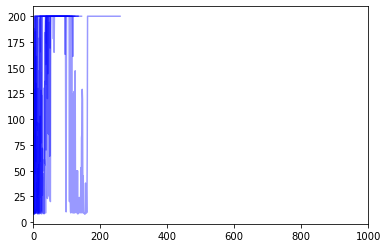

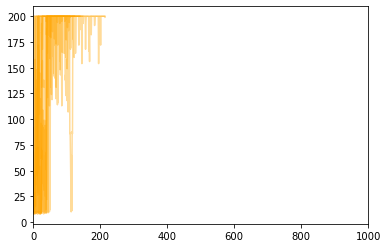

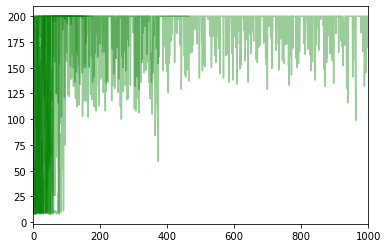

In [27]:
l = 0
for s in scores_stochastic:
    plt.plot(s, c='b', alpha = 0.4)
    l+=len(s)
plt.xlim(xmin=0, xmax=1000)
print('Stochastic: {}'.format(l))
l = 0
plt.figure()

for s in scores_steepest:
    plt.plot(s, c='orange', alpha = 0.4)
    l+=len(s)
plt.xlim(xmin=0, xmax=1000)
print('Steepest: {}'.format(l))
l = 0

plt.figure()
for s in scores_evo:
    plt.plot(s, c='green', alpha = 0.4)
    l+=len(s)
plt.xlim(xmin=0, xmax=1000)
print('Evo: {}'.format(l))
l = 0

In [28]:
ls = []

for g in scores_steepest:
    ls.append(len(g))

ValueError: setting an array element with a sequence.

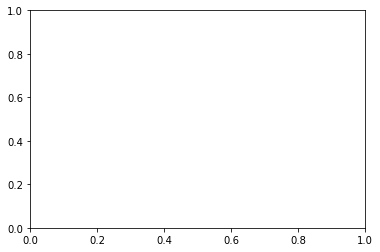

In [32]:
plt.hist(ls)